An example illustrating how to use our model to fit to a dataset containing events, times, and TMB values.  When comparing different models test folds should be used.

In [ ]:
import pathlib
path = pathlib.Path.cwd()
if path.stem == 'tmb_survival':
    cwd = path
else:
    cwd = list(path.parents)[::-1][path.parts.index('tmb_survival')]
import sys
sys.path.append(str(cwd))
import pickle
import numpy as np
from model.model import Encoders, NN
from model.layers import Losses
from model import utils
import tensorflow as tf
from lifelines.utils import concordance_index
from matplotlib import pyplot as plt
import pickle

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[-1], True)
tf.config.experimental.set_visible_devices(physical_devices[-1], 'GPU')

Load a data table for TCGA SKCM.

In [2]:
df = pickle.load(open(cwd / 'files' / 'SKCM_data.pkl', 'rb'))

Instantiate a log transformer object

In [3]:
t = utils.LogTransform(bias=4, min_x=0)

Prepare the data.

In [4]:
tmb = t.trf(df.tmb.values)[:, np.newaxis]
times = df['OS.time'].values[:, np.newaxis]
events = df['OS'].values[:, np.newaxis]
cancer_strat = np.zeros_like(df['tmb']) ##no cancer info, if there are multiple cancers can stratify by cancer type
y_label = np.stack(np.concatenate([times, events, cancer_strat[:, np.newaxis]], axis=-1))

Create a tensorflow dataset.

In [ ]:
ds_all = tf.data.Dataset.from_tensor_slices((
                                            (
                                                tmb
                                            ),
                                            (
                                                y_label,
                                            ),
                                            ))

ds_all = ds_all.batch(len(y_label), drop_remainder=False).repeat()

Create a callback to stop training.

In [6]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=30, mode='min', restore_best_weights=True)]

Create our model.  The model allows for a list of encoders for if there are multiple inputs.  We have a single input, TMB, so we only need one encoder.

In [7]:
encoder_1 = Encoders.Encoder(shape=(1,), layers=(128, 128), dropout=.05)
net = NN(encoders=[encoder_1.model], layers=(), norm=True)
net.model.compile(loss=Losses.CoxPH(cancers=1),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

Fit the model.

In [9]:
net.model.fit(ds_all, callbacks=callbacks, epochs=500, steps_per_epoch=10)

Epoch 1/500


2024-04-04 16:28:14.712916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [450,3]
	 [[{{node Placeholder/_1}}]]
2024-04-04 16:28:17.366928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-04 16:28:17.438540: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x66afd70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-04 16:28:17.438573: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A2000 Laptop GPU, Compute Capability 8.6
2024-04-04 16:28:17.482583: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproduce

10/10 [==============================] - 5s 11ms/step - loss: 2.5918
Epoch 2/500
10/10 [==============================] - 0s 10ms/step - loss: 2.5528
Epoch 3/500
10/10 [==============================] - 0s 10ms/step - loss: 2.5248
Epoch 4/500
10/10 [==============================] - 0s 10ms/step - loss: 2.5284
Epoch 5/500
10/10 [==============================] - 0s 9ms/step - loss: 2.5245
Epoch 6/500
10/10 [==============================] - 0s 9ms/step - loss: 2.5135
Epoch 7/500
10/10 [==============================] - 0s 9ms/step - loss: 2.5177
Epoch 8/500
10/10 [==============================] - 0s 10ms/step - loss: 2.5139
Epoch 9/500
10/10 [==============================] - 0s 10ms/step - loss: 2.5086
Epoch 10/500
10/10 [==============================] - 0s 9ms/step - loss: 2.5094
Epoch 11/500
10/10 [==============================] - 0s 9ms/step - loss: 2.5000
Epoch 12/500
10/10 [==============================] - 0s 10ms/step - loss: 2.5057
Epoch 13/500
10/10 [======================

Obtain the model risks.

In [10]:
risks = net.model.predict(ds_all, steps=1)

1/1 [==============================] - 0s 61ms/step


Plot the risks versus TMB (logged).

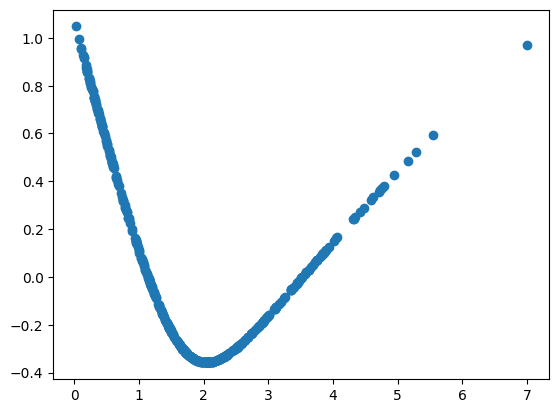

In [11]:
plt.scatter(tmb, risks)

Check the concordance index.

In [13]:
concordance_index(times, -risks, events)

0.621805561345729